# compute llc4320 temporal spectra

In [1]:
import os, sys

import numpy as np
import dask
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline

import mitequinox.utils as ut
import mitequinox.sigp as sp

In [2]:
from dask_jobqueue import PBSCluster

cluster = PBSCluster(cores=12, processes=6, walltime='06:00:00')
w = cluster.scale(jobs=20) # 2TB of RAM

# postprocessing
#cluster = PBSCluster()
#w = cluster.scale(jobs=4) # 2TB of RAM

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
cluster

---
# compute rotary spectra


In [5]:
#grd = load_grd(ftype='nc').reset_coords()
grd = ut.load_grd(['hFacW', 'hFacS', 'XC', 'YC', 'Depth'])
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) & (grd.hFacS.rename({'j_g': 'j'}) == 1) )
grd = (grd
       .assign_coords(mask=mask)
       .drop_vars(['hFacW', 'hFacS'])
       .reset_coords()
      )

In [16]:
# spatial strides
dij=2
with_mean = False

# load data
dsu = xr.open_zarr(ut.work_data_dir+'rechunked/%s.zarr'%('SSU'))
dsv = xr.open_zarr(ut.work_data_dir+'rechunked/%s.zarr'%('SSV'))
ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
              compat='equals').assign_coords(**grd)

# spatial subsetting, temporal rechunking
ds = ds.isel(i=slice(0,None,dij), j=slice(0,None,dij))
ds = ds.chunk({'time': -1})

ds['SSUV'] = ds['SSU'].fillna(0.) + 1j * ds['SSV'].fillna(0.)    

# global demean
if not with_mean:
    ds["SSUV"] = ds["SSUV"] - ds["SSUV"].mean("time")

ds = ds.drop_vars(['SSU', 'SSV'])

# should show the size of the dataset to know if we can load it in memory
print('dataset size: %.1f GB' %(ds.nbytes / 1e9))
# 1TB

ds = ds.persist()

dataset size: 1065.7 GB


In [18]:
T_window = 60 # window length in days
N_window = T_window*24  # in steps

# spectral computation
# need to run once to get frequency
f, E = sp.get_E(ds['SSUV'].isel(i=2,j=2), nperseg=N_window)
#
E = sp.get_E(ds['SSUV'], f=f, nperseg=N_window)

# store
Efile = os.path.join(ut.work_data_dir,
                     'spectra/{}_T{}.zarr'.format('SSUV', T_window)
                    )
if not with_mean:
    Efile = Efile.replace(".zarr", "_nomean.zarr")
    
%time E.to_dataset().to_zarr(Efile, mode='w')

/home/mp/pontea/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


CPU times: user 41.2 s, sys: 3.68 s, total: 44.9 s
Wall time: 1min 44s


In [19]:
cluster.close()

---

## SST/SSS

In [5]:
#grd = load_grd(ftype='nc').reset_coords()
grd = load_grd(['hFacW', 'hFacS', 'XC', 'YC', 'Depth']) #.reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) & (grd.hFacS.rename({'j_g': 'j'}) == 1) )
grd = (grd
       .assign_coords(mask=mask)
       .drop_vars(['hFacW', 'hFacS'])
       .reset_coords()
      )

In [10]:
v = 'SST'
#v = 'SSS'

# spatial strides
dij=2
Nb=60*24 # window length

Efile = work_data_dir+'spectra/%s.zarr'%(v)

rmtree(Efile, ignore_errors=True)

# load data
ds = xr.open_zarr(work_data_dir+'rechunked/%s.zarr'%(v)).assign_coords(**grd)

# spatial subsetting and temporal rechunking
ds = ds.isel(i=slice(0,None,dij), j=slice(0,None,dij))
ds = ds.chunk({'time': -1})

# fillna
ds[v] = ds[v].fillna(0.)

# should show the size of the dataset to know if we can load it in memory
print('dataset size: %.1f GB' %(ds.nbytes / 1e9))
# 1TB

ds = ds.persist()

dataset size: 533.0 GB


In [11]:
# spectral computation

# TO DO: swith to one sided spectra !! "return_onesided": True

# need to run once to get frequency
f, E = get_E(ds[v].isel(i=2,j=2), nperseg=Nb, return_onesided=True)
#
E = get_E(ds[v], f=f, nperseg=Nb, return_onesided=True)

# store
%time E.to_dataset().to_zarr(Efile, mode='w')

CPU times: user 27.3 s, sys: 1.67 s, total: 29 s
Wall time: 1min 9s


In [12]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


---
# inspect result

In [5]:
Efile = work_data_dir+'spectra/tmp_%s.zarr'%('SSUV')

face=1
v = 'SSUV'

E = xr.open_zarr(Efile)[v].sel(face=face).fillna(0.)
E = E.persist()
print(E)
print('\n data size: %.1f GB' %(E.nbytes / 1e9))

<xarray.DataArray 'SSUV' (j: 1080, i: 1080, freq_time: 1440)>
dask.array<where, shape=(1080, 1080, 1440), dtype=float64, chunksize=(48, 72, 1440), chunktype=numpy.ndarray>
Coordinates:
    Depth      (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    XC         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    YC         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    face       int64 1
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask       (j, i) bool dask.array<chunksize=(1080, 1080), meta=np.ndarray>

 data size: 13.4 GB


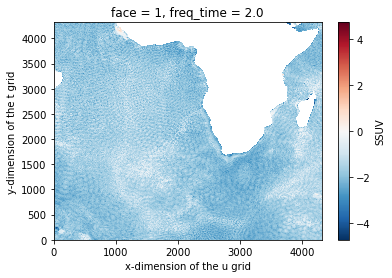

In [6]:
np.log10(E.sel(freq_time=2., method='nearest')).plot()

In [7]:
df = E.freq_time[1]-E.freq_time[0]
E2 = E.where(abs(abs(E.freq_time)-2.)<.2, other=0.).sum(dim='freq_time')*df
E2 = E2.where(E2>0)
print(E2)

<xarray.DataArray (j: 1080, i: 1080)>
dask.array<where, shape=(1080, 1080), dtype=float64, chunksize=(48, 72), chunktype=numpy.ndarray>
Coordinates:
    Depth    (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    face     int64 1
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    mask     (j, i) bool dask.array<chunksize=(1080, 1080), meta=np.ndarray>


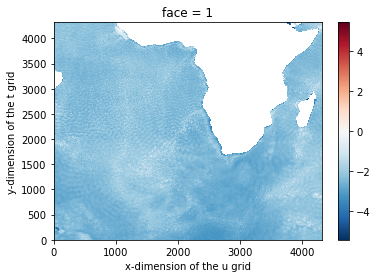

In [8]:
np.log10(E2).plot()

with concatenated faces

In [9]:
E = xr.open_zarr(Efile)[v].fillna(0.)
#E = E.persist()
print(E)
print('\n data size: %.1f GB' %(E.nbytes / 1e9))

<xarray.DataArray 'SSUV' (face: 13, j: 1080, i: 1080, freq_time: 1440)>
dask.array<where, shape=(13, 1080, 1080, 1440), dtype=float64, chunksize=(1, 48, 72, 1440), chunktype=numpy.ndarray>
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask       (face, j, i) bool dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

 data size: 174.7 GB


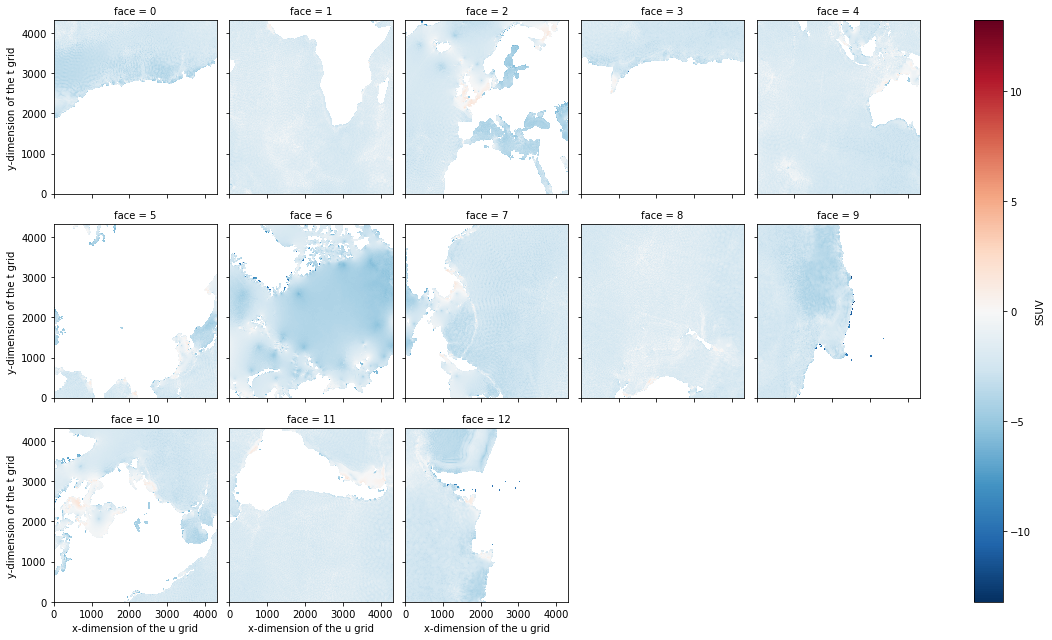

In [10]:
(np.log10(E.sel(freq_time=2., method='nearest'))
 .plot(col='face', col_wrap=5)) #, vmin=-1., vmax=1.)

---
# integrate in frequency bands



In [11]:
E = xr.open_zarr(Efile)[v].fillna(0.)
E = E.persist()
print(E)
print('\n data size: %.1f GB' %(E.nbytes / 1e9))

<xarray.DataArray 'SSUV' (face: 13, j: 1080, i: 1080, freq_time: 1440)>
dask.array<where, shape=(13, 1080, 1080, 1440), dtype=float64, chunksize=(1, 48, 72, 1440), chunktype=numpy.ndarray>
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask       (face, j, i) bool dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

 data size: 174.7 GB


In [12]:
f = 2*omega_earth*np.sin(np.deg2rad(E['YC']))
rps2cpd=86400/2./np.pi
domega = E.freq_time[1]-E.freq_time[0]

In [13]:
bands = {}
bands['semidiurnal'] = [1.9,2.1]
bands['diurnal'] = [.9,1.1]
bands['inertial'] = [(np.abs(f*rps2cpd)-.1).where((np.abs(f*rps2cpd)-.1)>=0, other=0.),
                     np.abs(f*rps2cpd)+.1]
bands['subdiurnal'] = [0,.5]
bands['high'] = [.5,24]
print(bands)

{'semidiurnal': [1.9, 2.1], 'diurnal': [0.9, 1.1], 'inertial': [<xarray.DataArray 'YC' (face: 13, j: 1080, i: 1080)>
dask.array<where, shape=(13, 1080, 1080), dtype=float32, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    mask     (face, j, i) bool dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>, <xarray.DataArray 'YC' (face: 13, j: 1080, i: 1080)>
dask.array<add, shape=(13, 1080, 1080), dtype=float32, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
    Depth    (face,

<xarray.DataArray (band: 1, face: 13, j: 1080, i: 1080)>
dask.array<broadcast_to, shape=(1, 13, 1080, 1080), dtype=float64, chunksize=(1, 1, 48, 72), chunktype=numpy.ndarray>
Coordinates:
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    mask     (face, j, i) bool dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * band     (band) <U11 'semidiurnal'


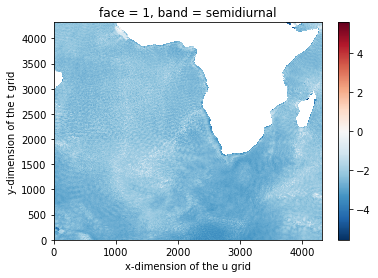

In [14]:
df = E.freq_time[1]-E.freq_time[0]
band = 'semidiurnal'
omegas = bands[band]
lE = (E.where(abs(E.freq_time)>=omegas[0], other=0.)
       .where(abs(E.freq_time)<=omegas[1], other=0.)
      .sum(dim='freq_time')*domega)
lE = lE.where(lE>0)
lE = lE.assign_coords(band=band).expand_dims('band')
#print(lE.coords)
print(lE)
np.log10(lE.sel(face=1)).plot()

In [15]:
D = []
for band, omegas in bands.items():
    lE = (E.where(abs(E.freq_time)>=omegas[0], other=0.)
           .where(abs(E.freq_time)<=omegas[1], other=0.)
          .sum(dim='freq_time')*domega)
    lE = lE.where(lE>0)
    lE = lE.assign_coords(band=band).expand_dims('band')
    D.append(lE)
ds = xr.concat(D, dim='band').chunk({'face':1,'i':None,'j':None}).rename('uv_variance').to_dataset()
print(ds)
#ds.to_zarr(work_data_dir+'spectra/%s_variance_per_band.zarr'%v)

<xarray.Dataset>
Dimensions:      (band: 5, face: 13, i: 1080, j: 1080)
Coordinates:
    Depth        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face         (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i            (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j            (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask         (face, j, i) bool dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * band         (band) object 'semidiurnal' 'diurnal' ... 'subdiurnal' 'high'
Data variables:
    uv_variance  (band, face, j, i) float64 dask.array<chunksize=(1, 1, 1080, 1080), meta=np.ndarray>


---

# old code: face by face

In [ ]:
# spatial strides
dij=1
Nb=60*24 # window length

for face in range(1,13):
    
    Efile = work_data_dir+'spectra/%s_f%02d.zarr'%('SSUV',face)
    
    if not os.path.isdir(Efile):
    
        # load data
        dsu = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('SSU',face))
        dsv = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('SSV',face))
        ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))
        #ds['SSU'] = ds['SSU'].where(abs(ds['SSU'])<10) # tmp: SSU.0000659952.shrunk is corrupted
        ds['SSUV'] = ds['SSU'].fillna(0.) + 1j * ds['SSV'].fillna(0.)    

        # spatial subsetting
        ds = ds.isel(i=slice(0,None,dij), j=slice(0,None,dij))
        
        # should show the size of the dataset to know if we can load it in memory
        print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

        # spectral computation
        # need to run once to get frequency
        f, E = get_E(ds['SSUV'].isel(i=2,j=2), nperseg=Nb)
        #
        E = get_E(ds['SSUV'], f=f, nperseg=Nb)

        # store
        E = E.to_dataset()
        %time E.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready done'%face)

---
# debug multitapper

In [3]:
face=1
    
# load data
dsu = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('SSU',face))
dsv = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('SSV',face))
ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
              compat='equals').assign_coords(**grd_rspec.sel(face=face))
#ds['SSU'] = ds['SSU'].where(abs(ds['SSU'])<10) # tmp: SSU.0000659952.shrunk is corrupted
ds['SSUV'] = ds['SSU'].fillna(0.) + 1j * ds['SSV'].fillna(0.)    

# spatial subsetting
ds = ds.isel(i=slice(0,10), j=slice(0,10))

print(ds)
# should show the size of the dataset to know if we can load it in memory
print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

# spectral computation
# need to run once to get frequency
#f, E = get_E(ds['SSUV'].isel(i=2,j=2))
#
#E = get_E(ds['SSUV'], f=f)


/home/mp/pontea/.conda/envs/equinox/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


<xarray.Dataset>
Dimensions:  (i: 10, j: 10, time: 8640)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(8640,)>
    face     int64 1
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9
    iters    (time) int64 dask.array<shape=(8640,), chunksize=(240,)>
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.68e+07 3.68e+07
    Depth    (j, i) float32 dask.array<shape=(10, 10), chunksize=(10, 10)>
    XC       (j, i) float32 dask.array<shape=(10, 10), chunksize=(10, 10)>
    YC       (j, i) float32 dask.array<shape=(10, 10), chunksize=(10, 10)>
    mask     (j, i) bool dask.array<shape=(10, 10), chunksize=(10, 10)>
Data variables:
    SSU      (time, j, i) float32 dask.array<shape=(8640, 10, 10), chunksize=(240, 10, 10)>
    SSV      (time, j, i) float32 dask.array<shape=(8640, 10, 10), chunksize=(240, 10, 10)>
    SSUV     (time, j, i) complex64 dask.array<shape=(8640, 10, 10), chunksize=(240, 10, 10)>
dat

In [4]:
from spectrum import dpss, pmtm

In [10]:
uv = ds.SSUV.isel(time=slice(0,240),i=0,j=0).values
print(uv.shape)
E = pmtm(uv, NW=2.5, k=4, show=False)
print(E[0].shape)
print(E[1].shape)
print(E[2].shape)

(240,)
(4, 256)
(256, 4)
(4,)


/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/spectrum/mtm.py:529: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/spectrum/mtm.py:530: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or 

In [ ]:
def _get_E(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = welch(x, fs=24., axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E
    
E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)


In [ ]:


def get_E(v, f=None, **kwargs):
    v = v.chunk({'time': len(v.time)})
    if 'nperseg' in kwargs:
        Nb = kwargs['nperseg']
    else:
        Nb = 80*24
        kwargs['nperseg']= Nb
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

---

In [ ]:
client.restart()

In [15]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
